In [1]:
%matplotlib inline

import glob
import fitsio
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from scipy.ndimage.measurements import label

In [2]:
fns = sorted(glob.glob("data/Q6/*.fits"))
data = np.empty((len(fns), 200, 200), dtype=np.float32)

for i, fn in enumerate(fns):
    data[i] = fitsio.read(fn)

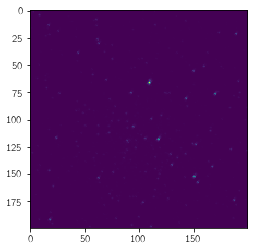

In [3]:
img = np.median(data, axis=0)
plt.imshow(img);

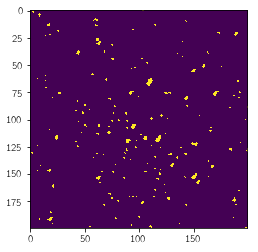

In [4]:
mu = np.median(img)
sigma = np.sqrt(np.median((img-mu)**2))
m = (img - mu) > 50*sigma

labels, nstar = label(m)

plt.imshow(m);

In [5]:
lcs = np.empty((nstar-1, len(data)), dtype=np.float32)
for star in range(nstar-1):
    lcs[star] = np.sum(data[:, labels == star+1], axis=1)
lcs = lcs / np.median(lcs, axis=-1)[:, None] - 1

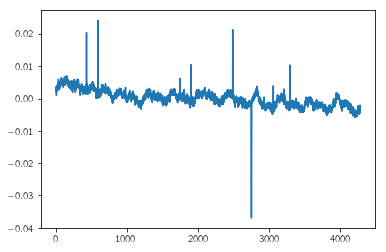

In [6]:
# target = data[:, 174:178, 164:169]
target = data[:, 174:180, 168:174]
target_lc = np.sum(target, axis=(1, 2))
target_lc = target_lc / np.median(target_lc) - 1
plt.plot(target_lc)

In [7]:
err = np.median(np.abs(np.diff(target_lc)))

In [8]:
err

0.000567019

In [80]:
T = tf.float32
np.random.seed(42)

session = tf.get_default_session()
if session is None:
    session = tf.InteractiveSession()

y = tf.constant(target_lc, dtype=T)
X = tf.constant(lcs.T, dtype=T)

A0 = X.eval()
w0 = np.linalg.solve(np.dot(A0.T, A0), np.dot(A0.T, y.eval()))

lam = tf.constant(1e-2, dtype=T)
lam_l2 = tf.constant(1.0, dtype=T)
w = tf.Variable(w0, dtype=T)

mod = tf.squeeze(tf.matmul(X, w[:, None]))
loss0 = tf.reduce_sum((y - mod)**2)
# loss0_huber = tf.losses.huber_loss(y, mod, delta=1e4)
loss1 = lam * tf.reduce_sum(tf.abs(w))
loss = loss0 + loss1

opt = tf.train.AdamOptimizer(1e-2).minimize(loss)

loss_l2 = loss0 + lam_l2 * tf.reduce_sum(w**2)
opt_l2 = tf.train.AdamOptimizer(1e-1).minimize(loss_l2)

XTX = tf.matmul(X, X, transpose_a=True)
XTy = tf.matmul(X, y[:, None], transpose_a=True)
bk = tf.reduce_sum(tf.abs(w))
wk = tf.squeeze(tf.linalg.solve(XTX + lam/bk * tf.eye(lcs.shape[0]), XTy))
opt_ze = tf.assign(w, wk)

init = tf.global_variables_initializer()
session.run(init)

In [81]:
session.run(init)
losses_l2 = np.empty(3000)
for i in range(len(losses_l2)):
    session.run(opt_l2)
    losses_l2[i] = loss_l2.eval()

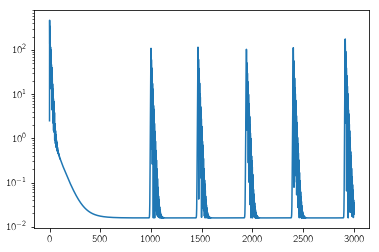

In [82]:
plt.plot(losses_l2)
plt.yscale("log")

In [57]:
session.run(init)
losses = np.empty(3000)
for i in range(len(losses)):
    session.run(opt)
    losses[i] = loss.eval()

In [58]:
session.run(init)
losses_ze = np.empty(3000)
for i in range(len(losses_ze)):
    session.run(opt_ze)
    losses_ze[i] = loss.eval()

In [59]:
session.run(init)
losses_fancy = np.empty(3000)
for i in range(len(losses_fancy)):
    if i < 10:
        session.run(opt_ze)
    else:
        session.run(opt)
    losses_fancy[i] = loss.eval()

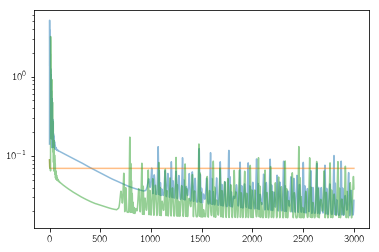

In [60]:
plt.plot(losses, alpha=0.5)
plt.plot(losses_ze, alpha=0.5)
plt.plot(losses_fancy, alpha=0.5)
plt.yscale("log")

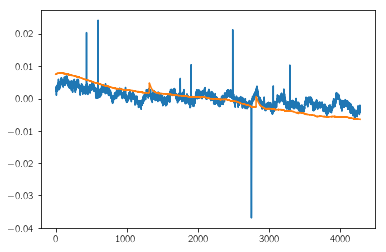

In [83]:
plt.plot(y.eval())
plt.plot(mod.eval())

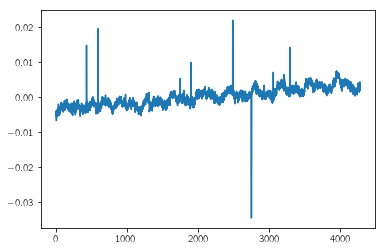

In [84]:
plt.plot(y.eval() - mod.eval())

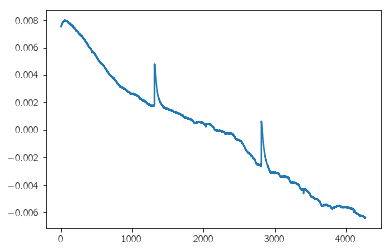

In [85]:
plt.plot(mod.eval())

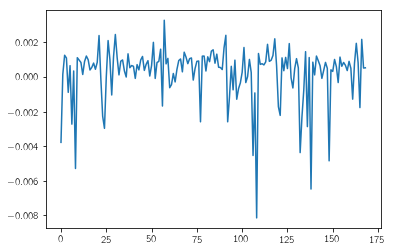

In [86]:
plt.plot(w.eval())

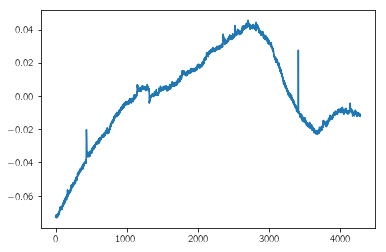

In [87]:
plt.plot(lcs[np.argmax(np.abs(w.eval()))])

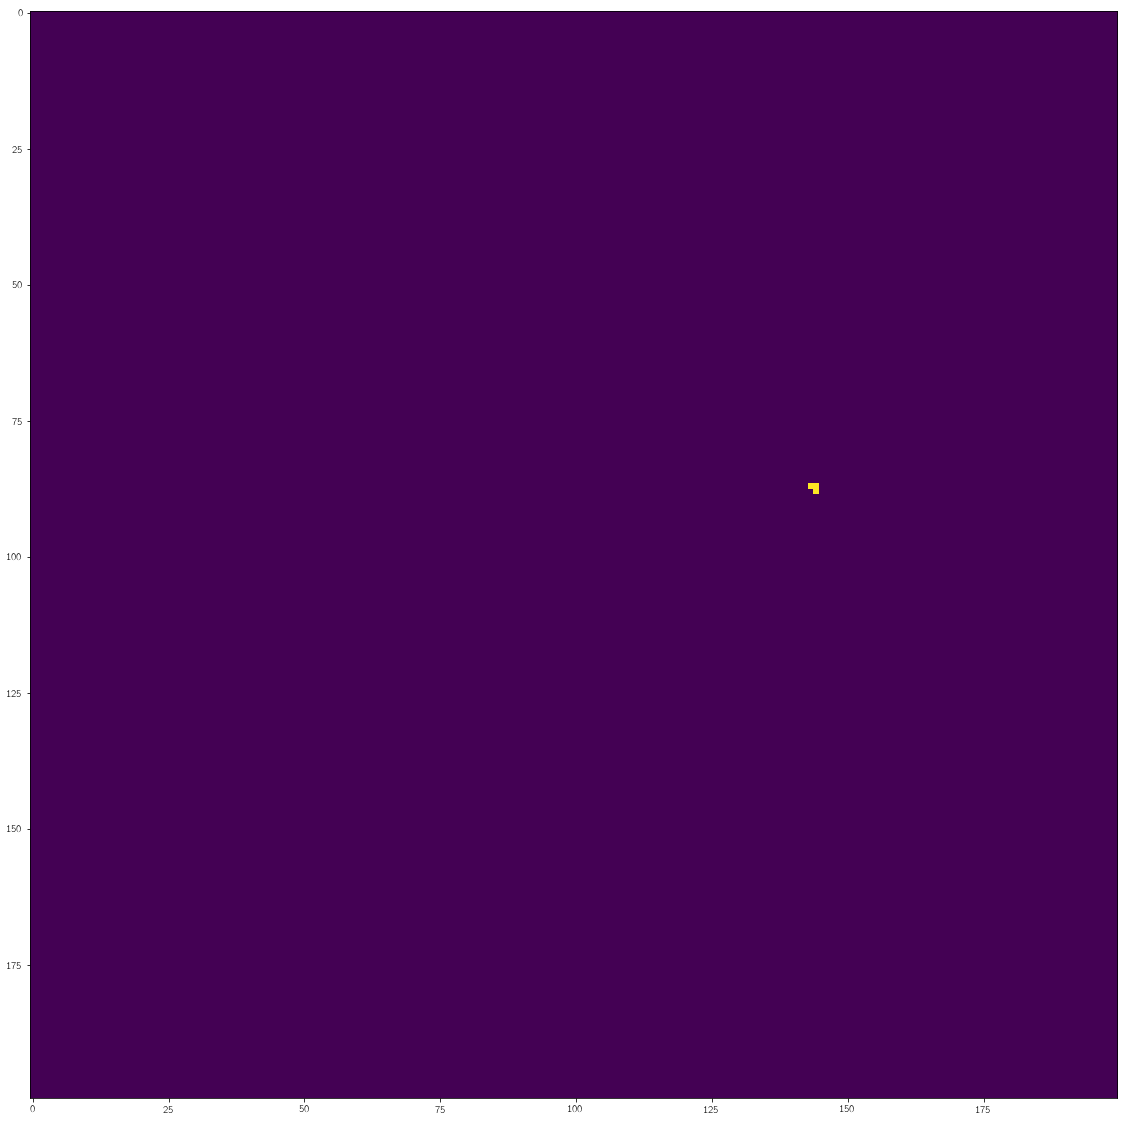

In [88]:
plt.figure(figsize=(20,20))
plt.imshow(labels == np.argmax(w.eval()) + 1)